In [3]:
# The code was removed by Watson Studio for sharing.

# Background and business understanding

At the Marketplace team at Trivago they have the goal to provide the right accommodations for their users and help their advertisers (online travel agencies, hotel chains and hoteliers) to run well performing campaigns on Trivago's website. The
balance between the interests of users and advertisers is established by the Exposure Algorithms, which determine what hotels and advertisers we present to the user and at what position they will be shown. One important objective of the algorithm is to anticipate how likely users are to click on a specific hotel.

In this project I will make use of Exploratory Data Analysis (EDA) and Machine Learning in **Spark** with the aim to predict how often a hotel will be clicked based on certain characteristics of the hotel. 

The dataset contains the following fields:


* __hotel_id__: Unique hotel identifier
* __city_id__:: Describes the city the hotel is located in
* __content score__:: describes the quality of the content that is provided for the hotel
on a scale from 0 (worst) to 100 (best)
* __n images__:: number of images that are available for the given hotel
* __distance to center__:: distance (in meters) of the hotel to the nearest city center
* __avg rating__:: average rating of the hotel on a scale from 0 (worst) to 100 (best)
* __n reviews__:: number of reviews that are available for that hotel
* __avg rank__:: average position the hotel had in the list
* __avg price__:: average price in Euro of the hotel
* __avg saving percent__:: average saving users achieve on this hotel by using trivago,
i.e. the relative difference between the cheapest and most expensive deal for the
hotel
* __stars__: the stars of the hotel
* __n clicks__: the number of clicks the hotel has received in a specific time frame
(target variable, unique to the training set)
    


In [4]:
# Import libraries
#########IBM watson studio specific####
import ibmos2spark 
from ibm_botocore.client import Config
import ibm_boto3
#######################################
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType, DecimalType
from pyspark.ml.regression import DecisionTreeRegressor,  RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import VectorAssembler,VectorIndexer,StringIndexer,OneHotEncoderEstimator,StringIndexerModel
from pyspark.ml import Pipeline, Transformer,Estimator,Model
from pyspark.ml.evaluation import RegressionEvaluator, Evaluator
from pyspark.sql import Window
from pyspark.ml.param.shared import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict



In [5]:
def upload_data_to_ibm_cos(credentials, df, tick):
    cos = ibm_boto3.client(service_name='s3', 
                           ibm_api_key_id=credentials['IBM_API_KEY_ID'], 
                           ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
                           ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
                           config=Config(signature_version='oauth'),
                           endpoint_url=credentials['ENDPOINT'])
    df.to_csv('{}.csv'.format(tick), sep=',', encoding='utf-8')
  
    try:
        res=cos.upload_file(Filename='{}.csv'.format(tick), Bucket=credentials['BUCKET'], Key='{}.csv'.format(tick))
        
    except Exception as e:
        print(Exception, e)
    else:
        print("{} data uploaded to IBM COS.".format(tick))
        os.remove('{}.csv'.format(tick))

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
#Read in data
test_df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('test_set.csv', 'clickrateprediction-donotdelete-pr-knwe64voh8v6lp'))


# Data Understanding

Let's start by viewing the data

In [8]:
train_df.take(5)

[Row(hotel_id='97674063206', city_id='134520', content_score='70', n_images='2', distance_to_center='1199', avg_rating='77', stars='4', n_reviews='861', avg_rank='17.55', avg_price='81.64', avg_saving_percent='18', n_clicks='0'),
 Row(hotel_id='97688892034', city_id='133876', content_score='67', n_images='3', distance_to_center='12585', avg_rating='90', stars='4', n_reviews='4371', avg_rank='17.383', avg_price='189.38', avg_saving_percent='28', n_clicks='4'),
 Row(hotel_id='98115438910', city_id='133732', content_score='39', n_images='3', distance_to_center='23491', avg_rating='83', stars='3', n_reviews='1005', avg_rank='16.438', avg_price='57.63', avg_saving_percent='27', n_clicks='44'),
 Row(hotel_id='98242792374', city_id='43772', content_score='59', n_images='8', distance_to_center='3291', avg_rating='73', stars='2', n_reviews='3084', avg_rank='7', avg_price='72.16', avg_saving_percent='2', n_clicks='4'),
 Row(hotel_id='98334382194', city_id='50532', content_score='66', n_images='1

In [9]:
test_df.take(5)

[Row(hotel_id='14942256073', city_id='122750', content_score='58', n_images='2', distance_to_center='11503', avg_rating='89', stars='0', n_reviews='168', avg_rank='13.5', avg_price='90.19', avg_saving_percent='32'),
 Row(hotel_id='16036037903', city_id='28134', content_score='68', n_images='4', distance_to_center='938', avg_rating='81', stars='5', n_reviews='735', avg_rank='13.667', avg_price='98.27', avg_saving_percent='19'),
 Row(hotel_id='288585940112', city_id='30578', content_score='19', n_images='0', distance_to_center='38982', avg_rating='NA', stars='0', n_reviews='0', avg_rank='20.462', avg_price='48.77', avg_saving_percent='0'),
 Row(hotel_id='129041645070', city_id='54398', content_score='47', n_images='0', distance_to_center='1683', avg_rating='80', stars='0', n_reviews='69', avg_rank='15', avg_price='72.32', avg_saving_percent='0'),
 Row(hotel_id='12460296563', city_id='63890', content_score='59', n_images='3', distance_to_center='1299', avg_rating='80', stars='3', n_review

In [10]:
# Explore data types
train_df.printSchema()

root
 |-- hotel_id: string (nullable = true)
 |-- city_id: string (nullable = true)
 |-- content_score: string (nullable = true)
 |-- n_images: string (nullable = true)
 |-- distance_to_center: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- n_reviews: string (nullable = true)
 |-- avg_rank: string (nullable = true)
 |-- avg_price: string (nullable = true)
 |-- avg_saving_percent: string (nullable = true)
 |-- n_clicks: string (nullable = true)



In [11]:
test_df.printSchema()

root
 |-- hotel_id: string (nullable = true)
 |-- city_id: string (nullable = true)
 |-- content_score: string (nullable = true)
 |-- n_images: string (nullable = true)
 |-- distance_to_center: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- n_reviews: string (nullable = true)
 |-- avg_rank: string (nullable = true)
 |-- avg_price: string (nullable = true)
 |-- avg_saving_percent: string (nullable = true)



Most of the fields have been imported as strings. Let's see what's happening

In [12]:
train_df.show(n=20)

+------------+-------+-------------+--------+------------------+----------+-----+---------+--------+---------+------------------+--------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_rank|avg_price|avg_saving_percent|n_clicks|
+------------+-------+-------------+--------+------------------+----------+-----+---------+--------+---------+------------------+--------+
| 97674063206| 134520|           70|       2|              1199|        77|    4|      861|   17.55|    81.64|                18|       0|
| 97688892034| 133876|           67|       3|             12585|        90|    4|     4371|  17.383|   189.38|                28|       4|
| 98115438910| 133732|           39|       3|             23491|        83|    3|     1005|  16.438|    57.63|                27|      44|
| 98242792374|  43772|           59|       8|              3291|        73|    2|     3084|       7|    72.16|                 2|       4|
| 98334382194|  50532|     

The 'NAs' in the data resulted in some fields being imported as character fields. Let's convert the character fields to numeric

In [13]:
exprs = ([F.col(x).cast(IntegerType()).alias(x) for x in train_df.columns if x not in ['avg_rank','avg_price','hotel_id']] 
         + [F.col(x).cast(FloatType()).alias(x) for x in train_df.columns if x in ['avg_rank','avg_price']])


In [14]:
exprs

[Column<b'CAST(city_id AS INT) AS `city_id`'>,
 Column<b'CAST(content_score AS INT) AS `content_score`'>,
 Column<b'CAST(n_images AS INT) AS `n_images`'>,
 Column<b'CAST(distance_to_center AS INT) AS `distance_to_center`'>,
 Column<b'CAST(avg_rating AS INT) AS `avg_rating`'>,
 Column<b'CAST(stars AS INT) AS `stars`'>,
 Column<b'CAST(n_reviews AS INT) AS `n_reviews`'>,
 Column<b'CAST(avg_saving_percent AS INT) AS `avg_saving_percent`'>,
 Column<b'CAST(n_clicks AS INT) AS `n_clicks`'>,
 Column<b'CAST(avg_rank AS FLOAT) AS `avg_rank`'>,
 Column<b'CAST(avg_price AS FLOAT) AS `avg_price`'>]

In [15]:
train_df = train_df.select(F.col('hotel_id').cast(DecimalType(precision=20)).alias('hotel_id'), *exprs)

In [16]:
exprs2 = ([F.col(x).cast(IntegerType()).alias(x) for x in test_df.columns if x not in ['avg_rank','avg_price','hotel_id']]
          + [F.col(x).cast(FloatType()).alias(x) for x in test_df.columns if x in ['avg_rank','avg_price']])


In [17]:
test_df = test_df.select(F.col('hotel_id').cast(DecimalType(precision=20)).alias('hotel_id'), *exprs2)

In [18]:
train_df.printSchema()

root
 |-- hotel_id: decimal(20,0) (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- content_score: integer (nullable = true)
 |-- n_images: integer (nullable = true)
 |-- distance_to_center: integer (nullable = true)
 |-- avg_rating: integer (nullable = true)
 |-- stars: integer (nullable = true)
 |-- n_reviews: integer (nullable = true)
 |-- avg_saving_percent: integer (nullable = true)
 |-- n_clicks: integer (nullable = true)
 |-- avg_rank: float (nullable = true)
 |-- avg_price: float (nullable = true)



This looks much better

In [19]:
train_df.show(n=5,vertical=True)

-RECORD 0-------------------------
 hotel_id           | 97674063206 
 city_id            | 134520      
 content_score      | 70          
 n_images           | 2           
 distance_to_center | 1199        
 avg_rating         | 77          
 stars              | 4           
 n_reviews          | 861         
 avg_saving_percent | 18          
 n_clicks           | 0           
 avg_rank           | 17.55       
 avg_price          | 81.64       
-RECORD 1-------------------------
 hotel_id           | 97688892034 
 city_id            | 133876      
 content_score      | 67          
 n_images           | 3           
 distance_to_center | 12585       
 avg_rating         | 90          
 stars              | 4           
 n_reviews          | 4371        
 avg_saving_percent | 28          
 n_clicks           | 4           
 avg_rank           | 17.383      
 avg_price          | 189.38      
-RECORD 2-------------------------
 hotel_id           | 98115438910 
 city_id            

In [20]:
# Count number of records
n_train = train_df.count()
n_test = test_df.count()
ncols_train = len(train_df.columns)
ncols_test = len(test_df.columns)

print('Number of records in training set: {}'.format(n_train))
print('Number of records in test set: {}'.format(n_test))
print('Number of columns in training set: {}'.format(ncols_train))
print('Number of columns in test set: {}'.format(ncols_test))

Number of records in training set: 396487
Number of records in test set: 132162
Number of columns in training set: 12
Number of columns in test set: 11


We see the training dataset contains 396 487 observations and the test dataset 132 162 observations. The trainng dataset contains 12 fields and the test 1 less due to the outcome/target variable (`n_clicks`) that had been omitted 

Let's split the data into a training and validation set before we start exploring the data. This is to avoid the so-called data snooping bias

In [21]:
train_data, validation_data = train_df.randomSplit([0.7,0.3],seed=7873)

In [22]:
n_train = train_data.count()
n_validation = validation_data.count()
number_cols = len(validation_data.columns)

print('Number of records in training set: {}'.format(n_train))
print('Number of records in validation set: {}'.format(n_validation))

Number of records in training set: 277316
Number of records in validation set: 119171


# Data Exploration

Let's start by investigating the data by drawing up some summary statistics

In [23]:
summary_stats = train_data.describe().cache()

In [24]:
num_col = [col for col in summary_stats.columns if col != 'summary']

In [25]:
# Format values for easier reading
summary_stats = summary_stats.select(summary_stats['summary'],*(F.format_number(F.col(c).cast("float"),2).alias(c) for c in num_col))

In [26]:
# Export to a Pandas Dataframe for easier viewing
summary_stats_pd = summary_stats.toPandas()

In [27]:
summary_stats_pd

,summary,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_saving_percent,n_clicks,avg_rank,avg_price
0,count,"277,316.00","276,936.00","276,936.00","276,935.00","276,920.00","200,090.00","276,894.00","276,920.00","277,209.00","277,316.00","277,316.00","277,209.00"
1,mean,"132,521,697,280.00","149,158.23",50.99,259.61,"15,923.48",81.61,1.16,912.56,7.19,13.80,14.68,109.20
2,stddev,"103,357,382,656.00","219,302.55",11.56,"17,856.43","268,861.62",6.02,1.62,"2,417.51",13.11,121.25,5.61,147.73
3,min,"155,858,464.00",2.00,7.00,-1.00,0.00,40.00,0.00,0.00,0.00,0.00,1.00,4.00
4,max,"323,711,369,216.00","878,736.00",81.00,"2,393,911.00","18,341,550.00",97.00,5.00,"283,089.00",99.00,"13,742.00",100.00,"7,957.34"


In [28]:
columns_perc_missing = train_data.select(*(F.mean(F.col(column).isNull().cast("int")).alias(column) for column in train_data.columns))

In [29]:
columns_perc_missing.toPandas()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_saving_percent,n_clicks,avg_rank,avg_price
0,0.0,0.00137,0.00137,0.001374,0.001428,0.278477,0.001522,0.001428,0.000386,0.0,0.0,0.000386


As can be seen from the above summary statistics, there is definitely some data cleaning that needs to be done. The following issues can be identified:
* `n_images` having a -1 value and very large values
* `Stars` having a zero rating - not sure whether that is possible
* `distance_to_centre` having extremely large (and obvious erroneous) values in some instances. A possible suggestion would be to replace the implausable values with missing values or to truncate the value
* Quite a lot of missing values for `avg_rating`. This might be due to the fact that these hotels haven't been rated yet by users. This should be checked by overlaying it with the `n reviews`variable. 


For the EDA part, we export the data to a Pandas Dataframe. Usually this won't be possible when working with tens of millions of records. A sample of the data would then usually suffice or some aggration beforehand. 

In [31]:
train_data_pd = train_data.toPandas()

Let's draw up some histograms. It will give us a better idea of the distributions

In [30]:
def plot_histogram(df,col):
    '''
    Draws up a histogram of a variable
    
    Arguments:
        df: A Pandas dataframe
        col: string. The field that needs to be plotted
    Output:
        None
    '''
    
    non_missings = df.loc[~df[col].isnull(),col]
    sns.distplot(non_missings,bins=30)

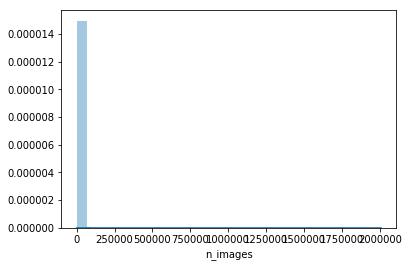

In [30]:
plot_histogram(train_data_pd,'n_images')

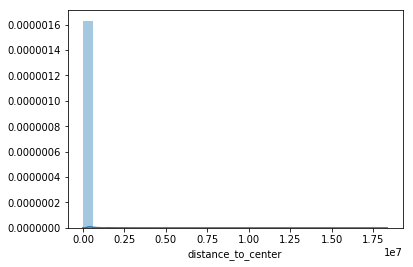

In [31]:
plot_histogram(train_data_pd,'distance_to_center')

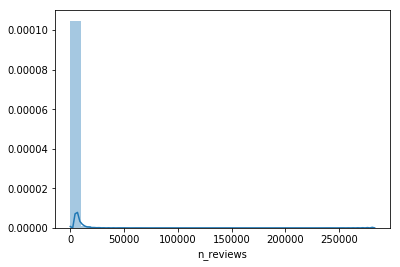

In [32]:
plot_histogram(train_data_pd,'n_reviews')

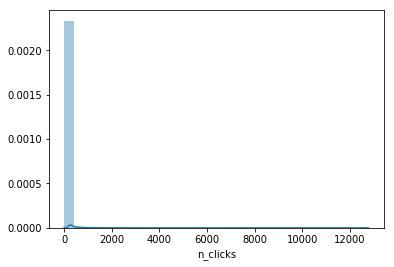

In [33]:
plot_histogram(train_data_pd,'n_clicks')

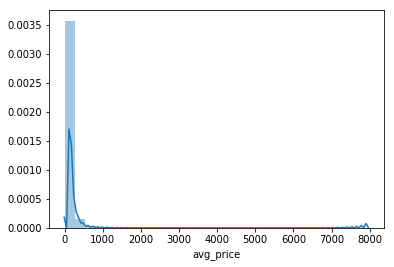

In [34]:
plot_histogram(train_data_pd,'avg_price')

From the above graphs, we see that most of the variable have a very long tail to the right. This is due to the existance of outliers. 

Let's calculate the 1st and 99th percentiles for some of the variables that looks suspicious by using the approxQuantile function. This method implements a variation of the Greenwald-Khanna algorithm (with some speed optimizations). The algorithm was first present in [[http://dx.doi.org/10.1145/375663.375670 Space-efficient Online Computation of Quantile Summaries]]
by Greenwald and Khanna.  The third argument referes to the relative target precision to achieve (>= 0). If set to zero, the exact quantiles are computed, which could be very expensive. Since our dataset is relatively small, we'll ask for the exact quantity.

In [35]:
percentiles = [0.01,0.05,0.95, 0.99]
num_vars = ['n_images','distance_to_center','n_reviews','n_clicks','avg_price']

In [36]:
percentile_values = train_data.approxQuantile(num_vars,percentiles,0)

In [37]:
pd.DataFrame(percentile_values,columns=percentiles,index=num_vars)

,0.01,0.05,0.95,0.99
n_images,0.00,0.000000,5.00000,9.00000
distance_to_center,0.00,6.000000,17125.00000,123376.00000
n_reviews,0.00,0.000000,4242.00000,10065.00000
n_clicks,0.00,0.000000,38.00000,258.00000
avg_price,12.23,22.549999,280.98999,605.02002


An interesting thing to note is that 95% of the hotels had 38 clicks and fewer and 99% 258 clicks and fewer!
Let's investigate some of these extreme values

In [38]:
# Find the record corresponding to the 99th percentile for distance_to_center
train_data.filter(train_data['distance_to_center'] == 123376).show()

+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|195864954682| 189204|           18|       0|            123376|      null|    0|        0|                 0|       0|    18.0|    40.26|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+



In [39]:
# Check some of the values for distance_to_center corresponding to this city
train_data.filter(train_data['city_id'] == 189204).show()

+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
| 10913861643| 189204|           67|       3|              1913|        83|    3|     1758|                 8|      20|   7.087|    86.73|
| 28198667551| 189204|           49|       2|              3853|        68|    3|      243|                 0|       0|   9.375|    57.11|
| 28198792163| 189204|           60|       3|               963|      null|    0|        0|                 0|      10|   12.25|    33.24|
| 47290534377| 189204|           60|       0|              2270|      null|    0|        0|                 0|       0|    13.5|    42.52|
| 47550163479| 189204|     

In [40]:
# Find the record corresponding to the maximum value for n_reviews
train_data.filter(train_data['n_reviews'] == 283089).show()

+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
| hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|
+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|267479658|  29334|           62|      13|              1940|        75|    4|   283089|                31|    1534|   8.147|    93.16|
+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+



In [41]:
# Check some of the values for n_reviews corresponding to this city
train_data.filter(train_data['city_id'] == 29334).show()

+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
| hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|
+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|265361254|  29334|           63|       6|               491|        81|    4|    32631|                32|     518|  11.926|   210.88|
|265392407|  29334|           66|       5|              6547|        82|    3|     6153|                34|       4|  17.137|   103.04|
|265517019|  29334|           67|       5|              6296|        83|    4|     6663|                40|      34|  15.785|     90.1|
|265548172|  29334|           59|       7|               560|        83|    4|     2892|                17|       4|  14.912|   151.12|
|265610478|  29334|           65|       4|      

In [42]:
# Find the record corresponding to the maximum value for avg_price
train_data.filter(train_data['avg_price']  > 7957).show()

+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|304775842682|  44036|           42|       0|              1156|      null|    0|        0|                 0|       0|     3.0|  7957.34|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+



In [43]:
# Check some of the values for n_reviews corresponding to this city
train_data.filter(train_data['city_id'] == 44036).show()

+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+
|264959006464|  44036|           49|       1|              1843|      null|    0|        0|                 0|       0|    20.0|   378.83|
|304775842682|  44036|           42|       0|              1156|      null|    0|        0|                 0|       0|     3.0|  7957.34|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+



From the above results we can see that the extreme values for `distance_to_center` are certainly not correct. 
The extreme values in the `n_review` field seems plausible. The maximum value for `avg_price` also doesn't look right.
When deciding whether to remove an outlier, it's important to distinguish between an outlier and an influentual value. For example, in linear regression an influential value will shift the trendline of the model- while an outlier wouldn't. Some algorithms are also more robust against outliers- like tree based mehtods for instance. I'll therefor make use of two approaches when creating my pipeline - the first by removing the outliers (didn't get to this :-( ), the second by leaving them in

##  Missing values 

The next step would be to investigate missing values in more detail. 

In [32]:
def missing_value_plot(df,columns):
    '''
    Draws up a missing values pattern plot
    Arguments:
        df: Pandas Dataframe
        columns: list. As list of columns
        
    Output:
        None
    '''
    
    number_cols = len(columns)
    nobs = df.shape[0]
    
    # Investigate patterns in the amount of missing data in each column.
   
    cross_tab_missing = np.zeros(shape=(number_cols,number_cols))
    miss_value_indicator = df.isnull()
    
    for i in range(number_cols):
        for j in range(number_cols):
            if j <= i:
                cross_tab_missing[i,j] = np.sum(miss_value_indicator.iloc[:,i] & miss_value_indicator.iloc[:,j])
    
    cross_tab_missing = cross_tab_missing/nobs
    
    mask = np.zeros_like(cross_tab_missing)
    for i in range(number_cols):
        for j in range(number_cols):
            if j > i:
                mask[i,j] = True
                
    sns.set(font_scale=1.4)
    fig, ax = plt.subplots()
    ax.set(facecolor='white')
    fig.set_size_inches(7, 7)
    ax=sns.heatmap(cross_tab_missing,xticklabels=columns,yticklabels=columns,mask=mask,cmap="YlGnBu")
    
                

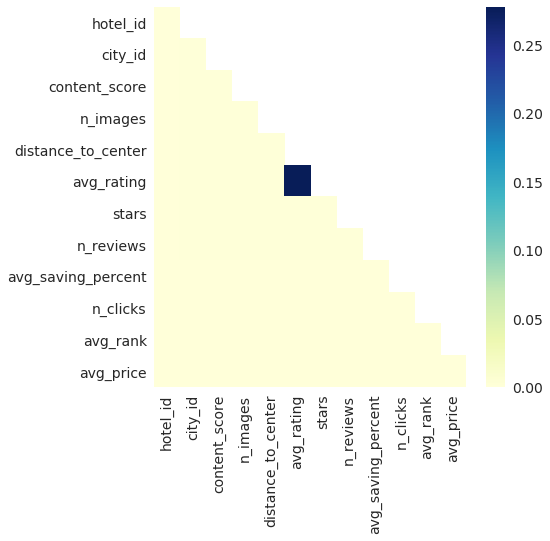

In [46]:
missing_value_plot(train_data_pd,train_data_pd.columns)

 We'll confirm whether the `ave_rating` field is missing in the case of no reviews

In [47]:
train_data.filter('avg_rating is null').select('n_reviews').describe().show()

+-------+---------+
|summary|n_reviews|
+-------+---------+
|  count|    76858|
|   mean|      0.0|
| stddev|      0.0|
|    min|        0|
|    max|        0|
+-------+---------+



We see this is indeed the case. Lastly we need to confirm that hotels with no reviews don't have a rating

In [48]:
train_data.filter('n_reviews == 0').select('avg_rating').describe().show()

+-------+----------+
|summary|avg_rating|
+-------+----------+
|  count|         0|
|   mean|      null|
| stddev|      null|
|    min|      null|
|    max|      null|
+-------+----------+



Next we'll check the percentage missign values for each hotel

In [40]:
row_perc_missing = train_data_pd.isna().mean(axis=1)*100

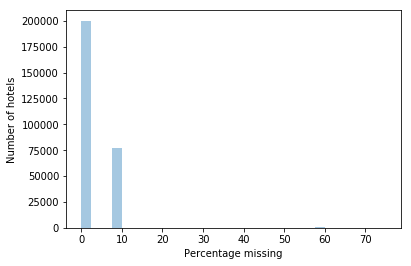

In [54]:
ax = sns.distplot(row_perc_missing,bins=30,kde=False);
ax.set_xlabel('Percentage missing');
ax.set_ylabel('Number of hotels');

There are definitely some outliers where missing values per row is concerned. Especially around 60%

So the following strategy will be used to deal with the missing values:
* missing values for `avg_rating` will be imputed with -1. An indicator variable will be created to indicate that there are no ratings for this hotel yet
* For all other missing values, the median value per city will be used. 
* Rows with more than 50% missing values will be dropped

In [51]:
# Calculate the threshold for dropping rows. Rows that have fewer non-missing values than the threshold will be dropped
threshold = int(len(train_data.columns) * 0.5)

In [52]:
threshold

6

In [53]:
train_data= train_data.dropna(thresh=threshold)

In [54]:
# Calculate the number of rows after entries were dropped
train_data.count()

277448

We see that only 348 rows (277796 - 277448) were dropped. Next we'll replace missing `avg_rating` values with -1 and create an new variable to indicate that there were no ratings for this hotel

In [30]:
train_data = train_data.withColumn('No_rating',F.when(F.col('avg_rating').isNull(),1).otherwise(0))
train_data = train_data.fillna(value=-1,subset=['avg_rating'])

In [56]:
# Check to see whether it looks right
train_data.filter('n_reviews == 0').show(5)

+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+---------+
| hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|n_clicks|avg_rank|avg_price|No_rating|
+---------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+--------+---------+---------+
|157229191|   2256|           50|       0|              2884|        -1|    2|        0|                 0|       0|  18.575|    87.24|        1|
|195142392|  13236|           59|       0|              8287|        -1|    0|        0|                 0|       0|  12.714|    77.14|        1|
|233024440|  27562|           37|      -1|               409|        -1|    0|        0|                 0|       0|    20.0|    30.91|        1|
|242899941| 790784|           65|       6|               315|        -1|    3|        0|                 1|      10|  13.761

We can write the following method to impute missing values with the median value for that particular city. This will help us tremendously when using pipelines further down. I used the follow [post](https://stackoverflow.com/questions/37270446/how-to-roll-a-custom-estimator-in-pyspark-mllib) as reference. An even better approach will be to use a nearest neighbour algorithm to impute the missing values with the mean of the closest neighbours. 

In [131]:
class HasInputCol(Params):
    
    inputcols = Param(Params._dummy(), "inputcols", "inputcols")

    def __init__(self):
        super(HasInputCol, self).__init__()

    def setInputCol(self, value):
        return self._set(inputcols=value)

    def getInputCol(self):
        return self.getOrDefault(self.inputcols)
    
class HasDataTypes(Params):
    
    
    datatypes = Param(Params._dummy(), "datatypes", "datatypes")

    def __init__(self):
        super(HasDataTypes, self).__init__()

    def setDataTypes(self, value):
        return self._set(datatypes=value)

    def getDataTypes(self):
        return self.getOrDefault(self.datatypes)
    

class HasMedians(Params):
    
    medians = Param(Params._dummy(), "medians", "medians")


    def __init__(self):
        super(HasMedians, self).__init__()

    def setMedians(self, value):
        return self._set(medians=value)

    def getMedians(self):
        return self.getOrDefault(self.medians)



class ImputeMedians(Estimator,HasInputCol, HasDataTypes):
    
    
    def _fit(self, dataset):
        
        columns = self.getInputCol()
               
        dataset = dataset.dropna(thresh=6)
        
        grp_window = Window.partitionBy('city_id')

        for var in columns:
            new_var_name = 'median_' + var
            magic_percentile = F.expr('percentile_approx({}, 0.5)'.format(var))
            dataset = dataset.withColumn(new_var_name, magic_percentile.over(grp_window))
        
        expr = [F.mean(F.col(field)).alias(field) for field in dataset.columns if field.startswith('median')]
        medians = dataset.groupBy('city_id').agg(*expr).collect()
        
        return (ImputeMediansModel()
            .setInputCol(columns)
            .setMedians(medians)
            .setDataTypes(self.getDataTypes()))


class ImputeMediansModel(Model, HasInputCol, HasMedians,HasDataTypes):

    def _transform(self, dataset):
        
        cols = self.getInputCol()
        datatypes = self.getDataTypes()
        medians = spark.createDataFrame(self.getMedians())
        
        dataset = dataset.join(medians,how='left',on ='city_id')
        
        
        exprs = [F.when(F.col(var).isNull(),'median_'+var).otherwise(F.col(var)).alias(var) for var in cols]
        
        non_missing_cols = [x for x in dataset.columns if x not in cols]
        dataset = dataset.select('hotel_id', *datatypes)
        dataset = dataset.dropna(how= 'any')

        return dataset    

In [32]:
# Create a list of fields I want to impute
miss_vars = ['content_score','n_images','distance_to_center','stars', 'n_reviews', 'avg_saving_percent','avg_price'] 

In [33]:
_exprs = [F.col(x).cast(IntegerType()).alias(x) 
          for x in train_data.columns if x == 'No_rating']

exprs.extend(_exprs) 

In [34]:
exprs

[Column<b'CAST(city_id AS INT) AS `city_id`'>,
 Column<b'CAST(content_score AS INT) AS `content_score`'>,
 Column<b'CAST(n_images AS INT) AS `n_images`'>,
 Column<b'CAST(distance_to_center AS INT) AS `distance_to_center`'>,
 Column<b'CAST(avg_rating AS INT) AS `avg_rating`'>,
 Column<b'CAST(stars AS INT) AS `stars`'>,
 Column<b'CAST(n_reviews AS INT) AS `n_reviews`'>,
 Column<b'CAST(avg_saving_percent AS INT) AS `avg_saving_percent`'>,
 Column<b'CAST(n_clicks AS INT) AS `n_clicks`'>,
 Column<b'CAST(avg_rank AS FLOAT) AS `avg_rank`'>,
 Column<b'CAST(avg_price AS FLOAT) AS `avg_price`'>,
 Column<b'CAST(No_rating AS INT) AS `No_rating`'>]

In [35]:
imputer = ImputeMedians().setInputCol(miss_vars).setDataTypes(exprs)

In [62]:
train_data_imp = imputer.fit(train_data).transform(train_data)

In [63]:
# Check to see whether everything looks good
train_data_imp.printSchema()

root
 |-- hotel_id: decimal(20,0) (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- content_score: integer (nullable = true)
 |-- n_images: integer (nullable = true)
 |-- distance_to_center: integer (nullable = true)
 |-- avg_rating: integer (nullable = true)
 |-- stars: integer (nullable = true)
 |-- n_reviews: integer (nullable = true)
 |-- avg_saving_percent: integer (nullable = true)
 |-- n_clicks: integer (nullable = true)
 |-- avg_rank: float (nullable = true)
 |-- avg_price: float (nullable = true)
 |-- No_rating: integer (nullable = false)



In [64]:
#Calculate the proportion of missing values per field
train_data_imp.select(*(F.mean(F.col(column).isNull().cast("int")).alias(column) 
                                               for column in train_data_imp.columns)).toPandas()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_saving_percent,n_clicks,avg_rank,avg_price,No_rating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Everything looks good. Lastly we can check how many records are in the dataset after dropping some additional rows

In [65]:
train_data_imp.count()

277294

Next we can check how many distinct cities there are

In [66]:
train_data_imp.select('city_id').distinct().count()

28825

There are way too many distinct number of cities to be included as features in the model, so we'll leave it out

Next we'll look  at some correlations and plots

In [67]:
def corr_matrix(df, variables):
    '''
    Draws up a correlation matrix of variables
    Arguments:
        df: A Spark dataframe
        variables: List. A list containing the variable names 
            
    Output:
        corr_matrix: A pandas dataframe containing the pairwise correlations
    '''   
    
    
    
    corr_list = []
    nvars = len(variables)
    for i in range(nvars):
        for j in range(nvars):
            corr_list.append(df.corr(variables[i],variables[j]))
            
    corr_array = np.asarray(corr_list).reshape(nvars,nvars)
    corr_matrix = pd.DataFrame(corr_array,columns=variables,index=variables)
    
    return corr_matrix

In [68]:
num_col = [col for col in train_data_imp.columns if col not in ['hotel_id','city_id']]

In [69]:
corr_matrix(df=train_data_imp, variables=num_col)

,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_saving_percent,n_clicks,avg_rank,avg_price,No_rating
content_score,1.000000,0.012652,-0.112685,0.508812,0.535455,0.283882,0.388205,0.097041,-0.141948,-0.075370,-0.526144
n_images,0.012652,1.000000,-0.000618,0.008201,0.011616,0.017682,0.006068,0.004111,-0.002421,-0.000891,-0.008568
distance_to_center,-0.112685,-0.000618,1.000000,-0.035570,-0.022968,-0.014546,-0.013915,-0.004696,-0.002494,0.005769,0.036707
avg_rating,0.508812,0.008201,-0.035570,1.000000,0.346643,0.216586,0.251246,0.063557,-0.155810,-0.078602,-0.990512
stars,0.535455,0.011616,-0.022968,0.346643,1.000000,0.339392,0.467634,0.132573,-0.166752,-0.011030,-0.360557
n_reviews,0.283882,0.017682,-0.014546,0.216586,0.339392,1.000000,0.366466,0.217603,-0.103131,-0.003218,-0.228361
avg_saving_percent,0.388205,0.006068,-0.013915,0.251246,0.467634,0.366466,1.000000,0.137368,-0.121493,-0.028549,-0.273771
n_clicks,0.097041,0.004111,-0.004696,0.063557,0.132573,0.217603,0.137368,1.000000,-0.083243,0.015455,-0.063445
avg_rank,-0.141948,-0.002421,-0.002494,-0.155810,-0.166752,-0.103131,-0.121493,-0.083243,1.000000,0.014636,0.158060
avg_price,-0.075370,-0.000891,0.005769,-0.078602,-0.011030,-0.003218,-0.028549,0.015455,0.014636,1.000000,0.096635


There is some mild correlation between some of the variables and number of clicks, albeit not very high. So the relationships may not be purely linear. We can plot these variables to see whether there are any relationship between the features and the number of clicks. We'll take a random sample of 10 000 observations, so that the plots don't become too cluttered

In [70]:
fraction = 10000/train_data_imp.count()
sample_data = train_data_imp.sample(withReplacement=False,seed=42,fraction=fraction )

In [71]:
sample_data.count()

10100

In [72]:
sample_df = sample_data.toPandas()

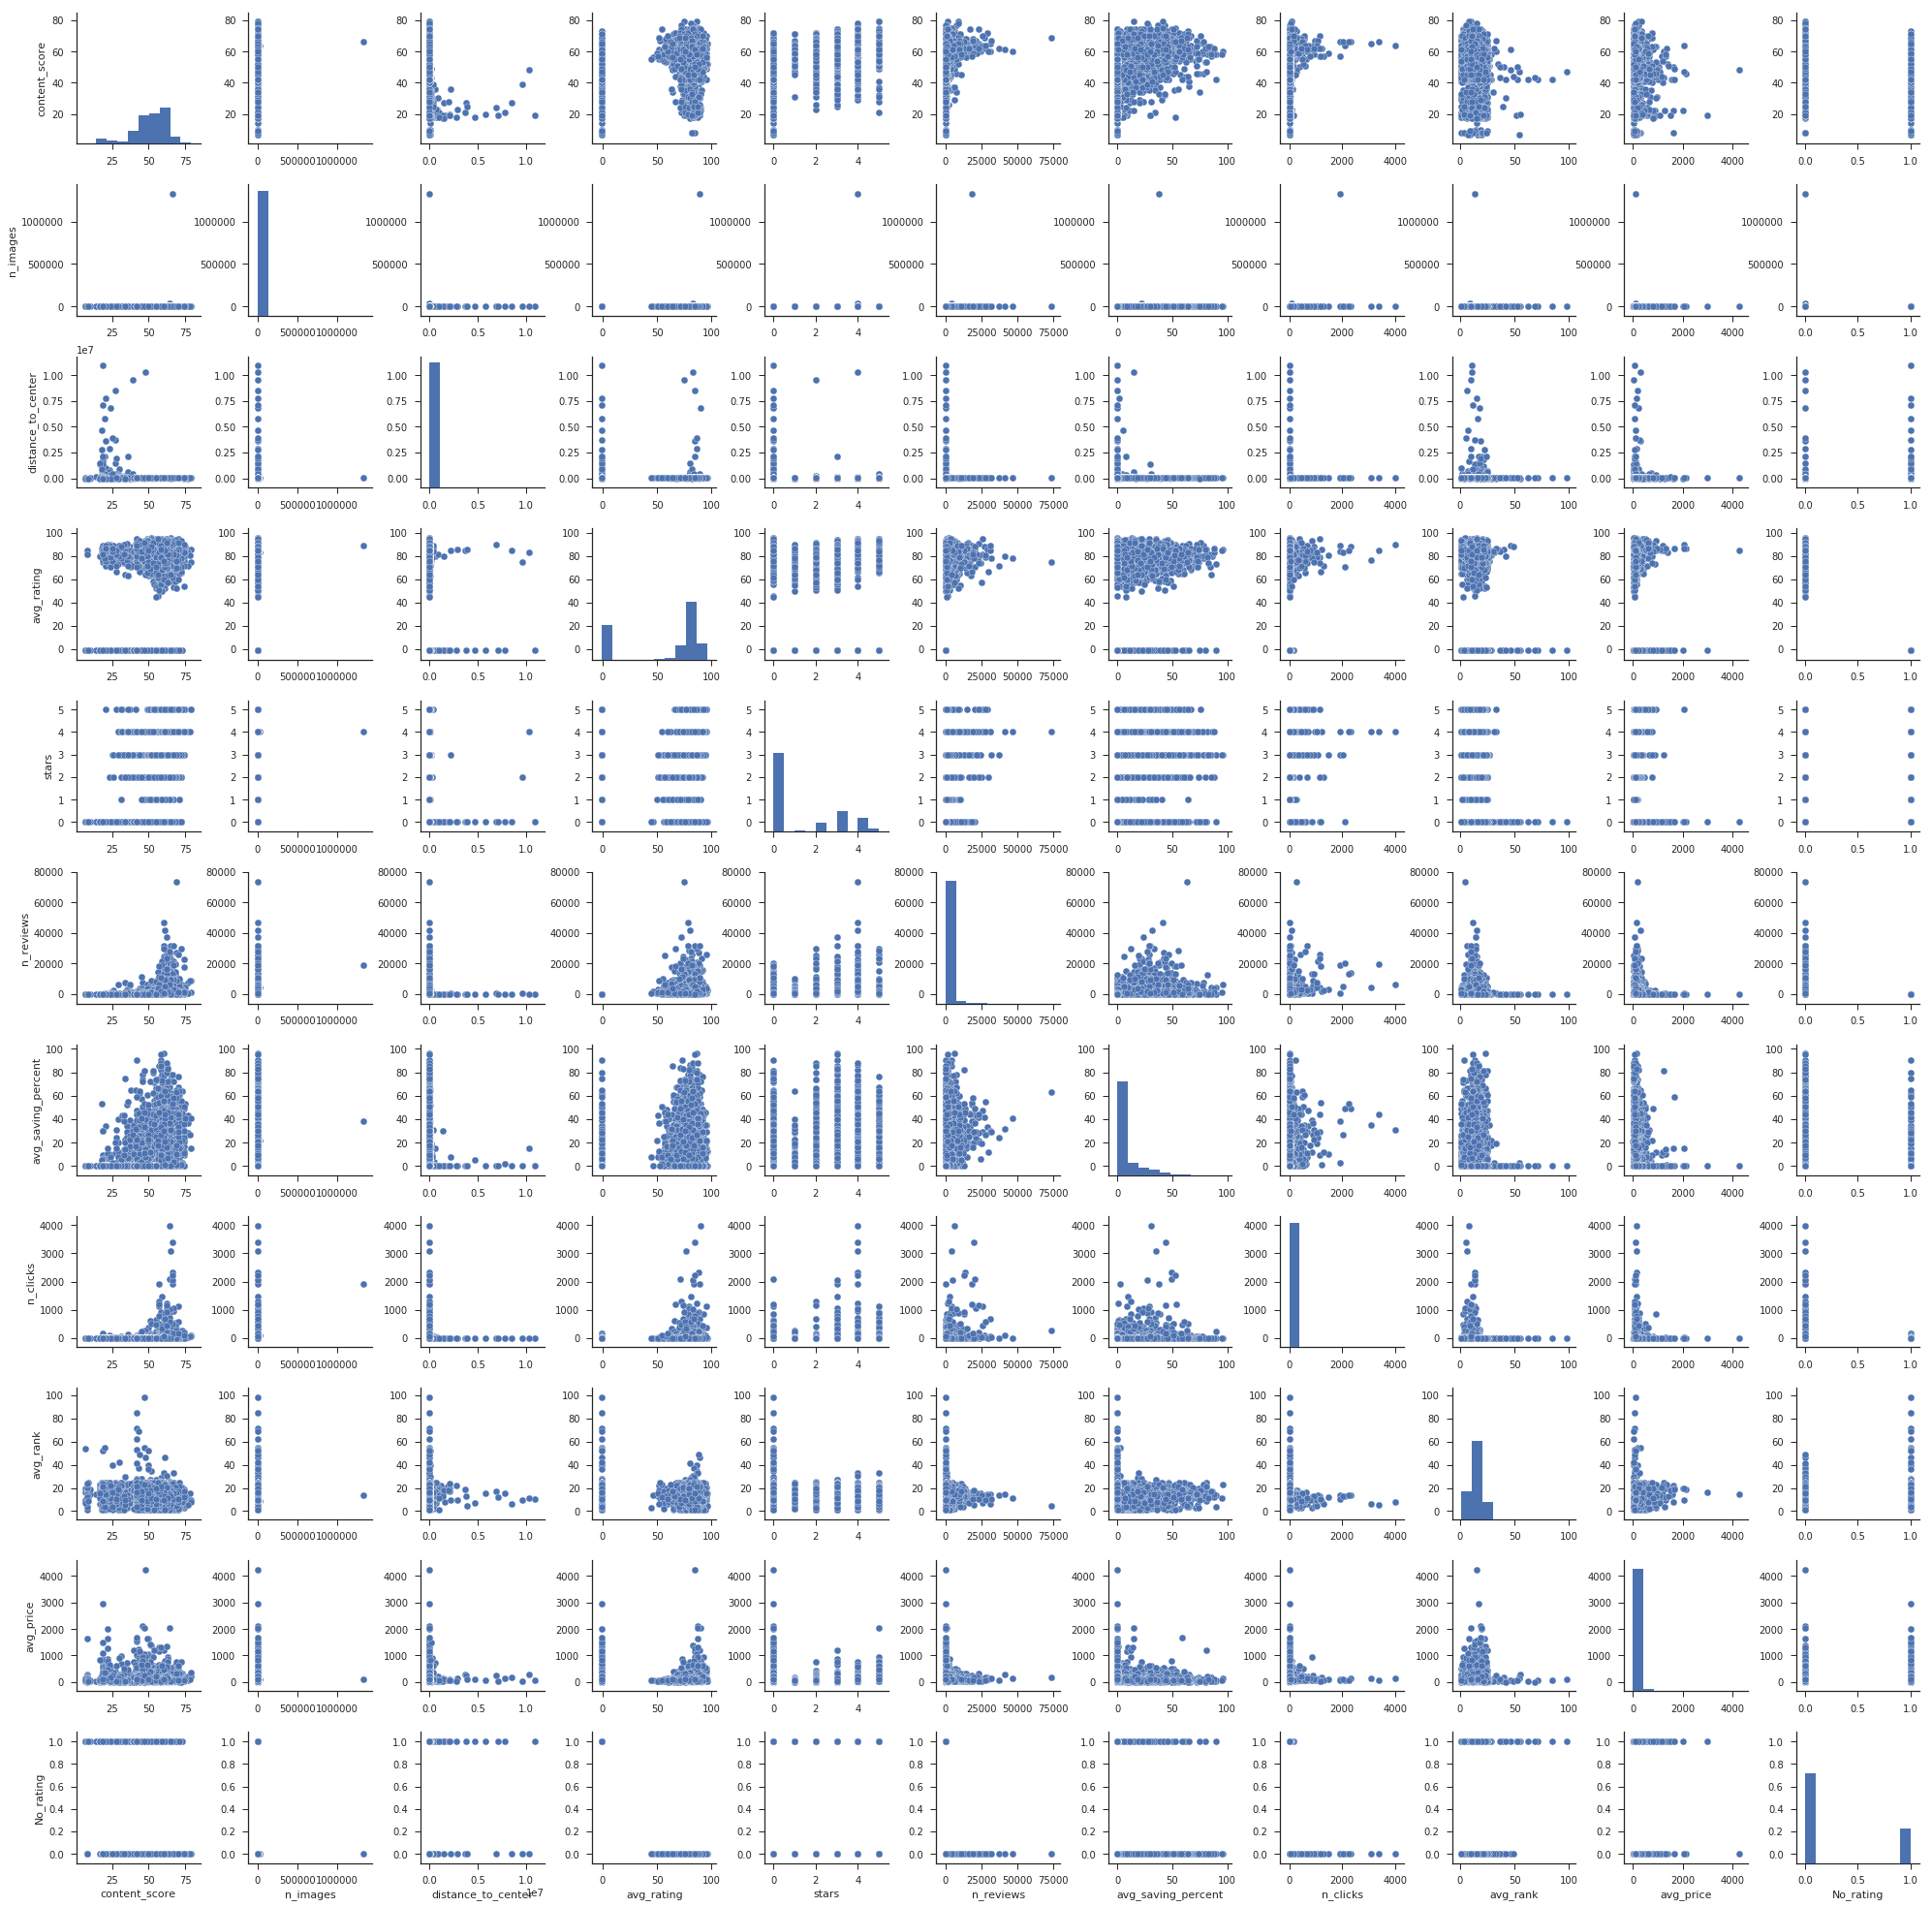

In [73]:
sns.set(style="ticks")
sns.pairplot(sample_df[num_col])
plt.show()


The ralationship between the outcome variable and  explanatory variables are very difficullt to discern.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


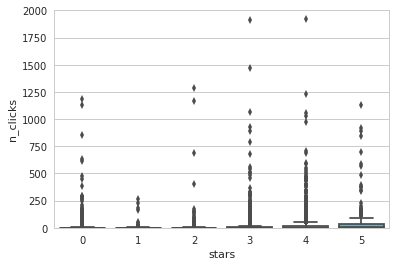

In [74]:
sns.set_style("whitegrid")   
plt.ylim(0, 2000)
sns.boxplot(x='stars',y="n_clicks",data=sample_df)
plt.show()

For the above plot there is a clearer relationship between the number of stars of the hotel and the number of clicks. 

# Modelling

Now we can finally fit our models. We will put together a simple Pipeline with the following stages:
* Impute_missing: Impute missing values
* StringIndexer : Flag columns that should be treated as categorical. We'll treat only the stars field as a categorical variable
* OneHotEncoderEstimator: One hot encoding of stars field
* VectorAssembler : Assemble the feature columns into a feature vector.
* GBTRegressor, RandomForestRegressor : This will use the different regression tree algorithms to learn how to predict number of clicks from the feature vectors.


The reason why I made use of the Random Forest and Gradient Boosting classifier was due the following strenghts of these algorithms:


* Can be used for classification as well as regression problems
* Can incorporate a mixture of numeric and categorical predictor variables.
* Handles missing values well
* They are invariant under (strictly monotone) transformations of the individual predictors. As a result scaling and/or more general transformations are not an issue
* They are immune to predictor outliers
* They perform internal future selection. They are therefore resistant to the inclusion of many irrelevant predictor variables.

They do however have the following weaknesses:

* Interpretability: while a single decision is highly interpretable, the linear combinations of trees with the Gradient boosting algorithm loses its interpretability.
* Speed: tends to be slow in terms of training time, especially when using a small learning rate. Due to the sequential nature of boosting it can't be parallelized


*Source: Hastie, T; Tibshirani, R; Friedman, J; The Elements of Statistical Learning*

*Cossock, David and Zhang, Tong (2008). Statistical Analysis of Bayes Optimal Subset Ranking*

In [75]:
train_data_imp.columns[2:]

['content_score',
 'n_images',
 'distance_to_center',
 'avg_rating',
 'stars',
 'n_reviews',
 'avg_saving_percent',
 'n_clicks',
 'avg_rank',
 'avg_price',
 'No_rating']

In [36]:
feature_columns = ['avg_rating','No_rating','content_score','n_images','distance_to_center','stars_ohe',
 'n_reviews', 'avg_saving_percent', 'avg_rank', 'avg_price']

In [37]:
# Setting up pipelines
stars_indexer = StringIndexer(inputCol='stars', outputCol='stars_index',handleInvalid='error')
ohe_stars = OneHotEncoderEstimator(inputCols=['stars_index'],outputCols=['stars_ohe'] ,dropLast=False)  
assembler = VectorAssembler(inputCols=feature_columns,outputCol='features')
gbt_model = GBTRegressor(featuresCol='features',labelCol='n_clicks',seed=3624)
rf_model = RandomForestRegressor(featuresCol='features',labelCol='n_clicks',seed=3624,numTrees=200)


In [38]:
pipeline1 = Pipeline(stages=[imputer,stars_indexer,ohe_stars,assembler,gbt_model])
pipeline2 = Pipeline(stages=[imputer,stars_indexer,ohe_stars,assembler,rf_model])

In [79]:
gbt_fitted = pipeline1.fit(train_data)
rf_fitted = pipeline2.fit(train_data)

Now we can see how our models performed on the validation dataset. But first we need to set up our evaluation metric. The evaluation metric will be the normalized weighted mean square error and is defined as follows:


Spark doesn't currently support this metric, so we'll need to create it from scratch so that it can be used to evaluate our different modesl and can easily be used in our pipeline

In [40]:
class Normalised_wmse(Evaluator):
    
    '''
    Normalized weighted mean square error evaluator for regression.

    Arguments:
        predictionCol: string. Name of the prediction column. Must be of type double (binary 0/1)
        labelCol: string. Name of the outcome/target column
       
    
    Output:
        None
    
    '''



    def __init__(self, predictionCol="prediction", labelCol='label'):
        
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        
   
    def _evaluate(self, X):
        
        def nwmse(y_actual,y_pred):
            
            w = np.log(y_actual+1) + 1 
            error = w * (y_actual - y_pred)**2
            
            return w, error

        n = X.count()
        output = X.select(self.labelCol, self.predictionCol).rdd.map(lambda x: nwmse(x[0],x[1]))
        nominator = output.map(lambda x: x[1]).sum()
        denominator = n * output.map(lambda x: x[0]).sum()
        error = nominator/denominator

        
         
        return error
    

    def isLargerBetter(self):
        return False

In [118]:
# Apply same steps to validation dataset that were applied to training set
validation_data= validation_data.dropna(thresh=6)
validation_data = validation_data.withColumn('No_rating',F.when(F.col('avg_rating').isNull(),1).otherwise(0))
validation_data = validation_data.fillna(value=-1,subset=['avg_rating'])

In [80]:
validation_data.count()

118531

In [88]:
rf_predicted = rf_fitted.transform(validation_data)
gbt_predicted = gbt_fitted.transform(validation_data)

Let's look at some of the predictions

In [89]:
rf_predicted.select('hotel_id','n_clicks','prediction').show(10)

+------------+--------+------------------+
|    hotel_id|n_clicks|        prediction|
+------------+--------+------------------+
|170067840748|       0| 2.228108827014619|
|275478377668|       2|0.9620445899359561|
|145225628570|       0|1.9109657561230735|
|168371061450|       0|1.3202703689309145|
|202781419130|       0|1.3425116928705723|
|  4726252783|       2|4.2937229527214615|
| 34790611198|       0|  4.38869717488341|
| 52168782647|      78|  8.92183476998809|
|321769368040|       2|2.9754938691987447|
| 75026455266|       8| 5.115701685310401|
+------------+--------+------------------+
only showing top 10 rows



In [101]:
gbt_predicted.select('hotel_id','n_clicks','prediction').show(10)

+------------+--------+--------------------+
|    hotel_id|n_clicks|          prediction|
+------------+--------+--------------------+
|145225628570|       0|   0.130925758182511|
|168371061450|       0|  1.8740628357766176|
|202781419130|       0|-0.23929637053596828|
|170067840748|       0|  1.8740628357766176|
|275478377668|       2|   0.608349319146124|
|  4726252783|       2|   3.300654485278272|
| 75026455266|       8|  1.6129503900905708|
|290743036138|       0|  1.8740628357766176|
|301413125556|       0|   0.608349319146124|
| 34790611198|       0|  2.8413996101189145|
+------------+--------+--------------------+
only showing top 10 rows



In [90]:
gbt_predicted_pd = gbt_predicted.select('hotel_id','n_clicks','prediction').toPandas()

In [107]:
gbt_predicted_pd['error'] = gbt_predicted_pd['n_clicks'] - gbt_predicted_pd['prediction']

In [109]:
#Summary stats of the residuals/errors
gbt_predicted_pd['error'].describe()

count    118466.000000
mean          0.148230
std         124.954346
min       -2240.994704
25%          -4.907852
50%          -1.390389
75%           0.252655
max       13255.306447
Name: error, dtype: float64

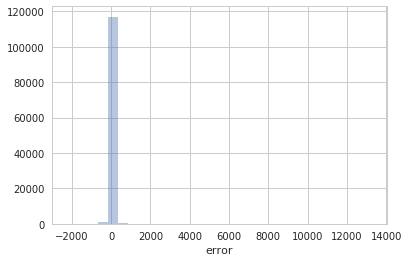

In [108]:
Histogram of the residuals
sns.distplot(gbt_predicted_pd['error'],bins=30,kde=False);

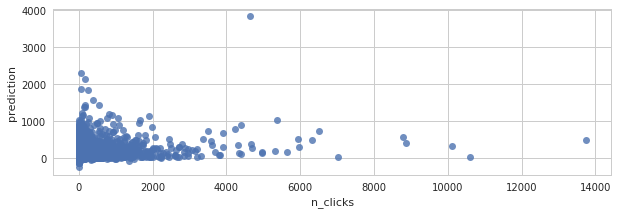

In [116]:
#Scatter plot of predicted versus actual clicks
fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(111)
sns.regplot(x='n_clicks',y='prediction',data=gbt_predicted_pd,ax=ax,fit_reg=False);
ax.set_aspect('equal')

We already see some issues where the predicted values are negative and the modeling struggling to predict clicks greater that 2000 correctly. There is of course no constraints in our model that states that the values need to be positive. We'll need to cater for that. But otherwise the model looks to be performing well. Let's calculate the Normalixed weighted mean squared errors (NWMSE) for the Random Forest and Gradient Boosting models

In [41]:
nwmse = Normalised_wmse(predictionCol="prediction", labelCol='n_clicks')

In [105]:
print('Random Forest NWMSE: {}'.format(nwmse.evaluate(rf_predicted)))

Random Forest NWMSE: 0.6679830054298218


In [106]:
print('Gradient Boosting NWMSE: {}'.format(nwmse.evaluate(gbt_predicted)))

Gradient Boosting NWMSE: 0.6496089848288603


Based on the NWMSE, the Gradient Boosting Classifier is performing best. We'll therefore tune the hyperparameters further to see if we can achieve an even better result

In [55]:
param_grid = (ParamGridBuilder()
               .addGrid(gbt_model.maxDepth, [2, 3, 5]) 
               .addGrid(gbt_model.minInstancesPerNode, [1,50,500]) 
#                .addGrid(gbt_model.subsamplingRate, [0.5,0.8,1.0]) left out due to time constraints
               .build())


In [56]:
# We'll run a gridsearch with 3 folds. Initially ran it with 5 folds, but had to be lowered due to time-constraints 
gridsearch = CrossValidator(estimator=pipeline1,estimatorParamMaps=param_grid,numFolds=3,evaluator=nwmse,parallelism = 10)

In [57]:
cvmodel = gridsearch.fit(train_data)

In [79]:
# Create dictionary of NWMSE for the different combinations of hyperparameters
gridsearch_metrics = defaultdict(list)
metric_i = 0
for depth in [2, 3, 5]:
    for instances in [1,50,500]:
        
        gridsearch_metrics['maxDepth'].append(depth)
        gridsearch_metrics['minInstancesPerNode'].append(instances)
        gridsearch_metrics['metric'].append(cvmodel.avgMetrics[metric_i])
        
        metric_i+=1

In [114]:
metrics_df  = pd.DataFrame(gridsearch_metrics)

Now we can plot the results of the gridsearch

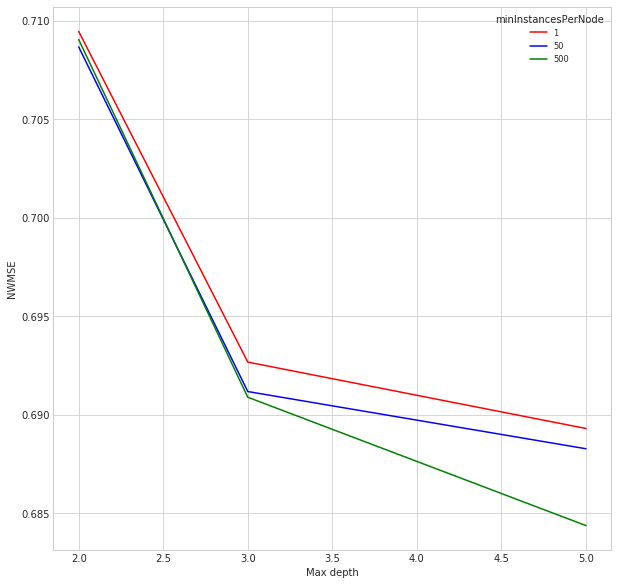

In [117]:

fig.clear()
fig, ax = plt.subplots(figsize = (10,10))

for instances,col in zip([1,50,500],['red','blue','green']):
    
    x = metrics_df.loc[metrics_df['minInstancesPerNode'] == instances,'maxDepth']
    y = metrics_df.loc[metrics_df['minInstancesPerNode'] == instances,'metric']
    
    ax.plot(x,y, 'k', c=col,label=instances)

ax.set_ylabel('NWMSE');
ax.set_xlabel('Max depth');
legend = ax.legend(loc='upper right', fontsize='small',title='minInstancesPerNode')
legend.get_frame().set_facecolor('C0')
plt.show()

From the above plot we can see that the following hyperparameters achieved the lowest NWMSE:
* Maximum depth of tree: 5
* Minimum instances per node: 500

It seems we can achieve even better results by increasing the depth of the tree further.

In [60]:
# Saving the best model
best_model = cvmodel.bestModel

We can view which variables came out most predictive by using the featureImportances method in the Gradient Boosting model

In [62]:
categories_mapping = {x._java_obj.getOutputCol(): x.labels for x in best_model.stages if isinstance(x, StringIndexerModel)}

In [68]:
categorical_vars = []
for var, categories in categories_mapping.items():
    for cat in categories:
        categorical_vars.append(var.replace('_index','_') + cat.strip(' '))

In [69]:
categorical_vars

['stars_0', 'stars_3', 'stars_4', 'stars_2', 'stars_5', 'stars_1']

In [72]:
feature_columns_plot = feature_columns[:5] + categorical_vars + feature_columns[6:]

In [75]:
def feature_importance_plot(model_obj,features):
    '''
    Plot the feature importance plot for a Spark model
    
    Arguments:
        model_obj: A spark model object
        features: list. A list containing the feature names
    Output:
        None
    '''
        
        
    feature_imp = [x for x in model_obj.stages[-1].featureImportances]
    fi_for_draw = pd.DataFrame({'feature': features, 'importance':feature_imp})
    fi_for_draw = fi_for_draw.sort_values(by="importance", ascending=False)
    sns.set_style("whitegrid")
    sns.barplot(data=fi_for_draw, x='importance', y='feature')
    plt.show()


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


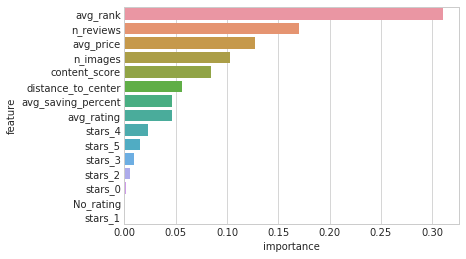

In [76]:
feature_importance_plot(best_model,feature_columns_plot)



The sum of  all importances is equal to 1. The most important feautures are the Average rank, Number of reviews and the average price. The number of stars the hotel has is least predictive.

Finally we can test the model on the validation dataset

In [119]:
validation_predicted = best_model.transform(validation_data)

In [121]:
print('Best model NWMSE on validation set: {}'.format(nwmse.evaluate(validation_predicted)))

Best model NWMSE on validation set: 0.6090193822169344


A nice improvement after tuning the hyperparameters

# Scoring of the test data

In [123]:
# Creating the additional feature
test_df = test_df.withColumn('No_rating',F.when(F.col('avg_rating').isNull(),1).otherwise(0))
test_df = test_df.fillna(value=-1,subset=['avg_rating'])

test_df.show()

+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+---------+---------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|avg_rank|avg_price|No_rating|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+---------+---------+
| 14942256073| 122750|           58|       2|             11503|        89|    0|      168|                32|    13.5|    90.19|        0|
| 16036037903|  28134|           68|       4|               938|        81|    5|      735|                19|  13.667|    98.27|        0|
|288585940112|  30578|           19|       0|             38982|        -1|    0|        0|                 0|  20.462|    48.77|        1|
|129041645070|  54398|           47|       0|              1683|        80|    0|       69|                 0|    15.0|    72.32|        0|
| 12460296563|  6389

In [126]:
# Investigate whether there are missing values
test_missing = test_df.select(*(F.mean(F.col(column).isNull().cast("int")).alias(column) for column in test_df.columns))

In [127]:
test_missing.toPandas()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_saving_percent,avg_rank,avg_price,No_rating
0,0.0,0.001173,0.001173,0.00118,0.001233,0.0,0.001324,0.001233,0.000439,0.0,0.000439,0.0


In [168]:
# Saving only the hotel_id field to a pandas dataframe
test_hotel_ids = test_df.select('hotel_id').toPandas()

In [154]:
# A bit of a quick and dirty hack job :-)
_exprs = [F.col(x).cast(IntegerType()).alias(x) 
          for x in test_df.columns if x == 'No_rating']

exprs2.extend(_exprs) 

In [156]:
best_model.stages[0].setDataTypes(exprs2)

ImputeMediansModel_4a57bbca8379813cd177

In [158]:
test_predictions = best_model.transform(test_df)

In [159]:
test_predictions.show()

+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+---------+---------+-----------+-------------+--------------------+------------------+
|    hotel_id|city_id|content_score|n_images|distance_to_center|avg_rating|stars|n_reviews|avg_saving_percent|avg_rank|avg_price|No_rating|stars_index|    stars_ohe|            features|        prediction|
+------------+-------+-------------+--------+------------------+----------+-----+---------+------------------+--------+---------+---------+-----------+-------------+--------------------+------------------+
| 27722151263|   1806|           55|       0|               715|        74|    3|      357|                 9|  15.133|    76.88|        0|        1.0|(6,[1],[1.0])|(15,[0,2,4,6,11,1...| 6.031367823950719|
| 42416803292|   4894|           57|       1|               125|        83|    0|      312|                 0|    11.4|     78.4|        0|        0.0|(6,[0],[1.0])|(15,[0,2,3,

In [170]:
# Saving only the predictions and hotel_id to a panda dataframe
predictions = test_predictions.select('hotel_id','prediction').toPandas()

In [176]:
predictions.set_index('hotel_id',inplace=True)

In [178]:
test_hotel_ids.set_index('hotel_id',inplace=True)

In [196]:
# Join the 2 dataframes
final_output = test_hotel_ids.join(predictions,how='left')

In [180]:
final_output.head()

,prediction
hotel_id,
14942256073,18.542467
16036037903,18.676100
288585940112,-0.754931
129041645070,1.764114
12460296563,4.674154


In [197]:
# For hotels that weren't scored, we set the prediction equal to 0
final_output.fillna(value=0,inplace=True)

In [198]:
# Drop the decimals 
final_output['n_clicks'] = final_output['prediction'].apply(lambda x: np.int(x))

In [199]:
# Set negative predictions equal to 0
final_output.loc[final_output['n_clicks']<0, 'n_clicks'] = 0


In [201]:
final_output.drop('prediction',axis=1,inplace=True)

In [202]:
final_output.head()

,n_clicks
hotel_id,
14942256073,18
16036037903,18
288585940112,0
129041645070,1
12460296563,4


In [206]:
# Save data to a csv file
upload_data_to_ibm_cos(cos_credentials, final_output, 'sample_submission')

sample_submission data uploaded to IBM COS.


# Results evaluation and discussion

I got some decent results using the Gradient boosting algorithm. As next steps, I would have tested the following to see whether it has an effect on model performance:
* Using a nearest neighbour algorithm to impute missing values. The median values per city might not be the best approach due to small subsample in some cities. From the analysis it was also seen that not all missing values were imputed using this approach.
* Truncating or replacing outliers with missing values
* Increase the number of iterations for the GBT. I made use of the default value of 20 iterations
* Search over more hyper parameter values

We saw that the average rank of the hotel was the most predictive feature. This makes sense because users usually don't like to scroll down too much! We see the same thing with Google's ranking algorithm. Additional variables that might have been included (considered) are time of the year (whether it's high season in a particular country/province), the proximity to tourist attractions and the number of hotels in a certain radius.   

The purpose of the NWMSE evaluation metric was to give more weight to predictions where the actual number of clicks were higher. The reason for this might be due to the fact that a large number of hotels had 0 clicks. The default option of a model algorithm might have been to set all predictions equal to 0. The mean square error metric might also make sense in this instance since it gives greater weight to outliers.

The click prediction is also just one component of Trivago's Exposure Algorithms. A recommendation system is a valuable tool in any company's toolkit these days. In the case of new users (so-called cold start problem) we can make use of a rank based system suggesting the most popular (based on rank) hotels for a particular city. For existing users we can use a collaborative filtering approach.

In terms of alternative models that I would have considered if time allowed was to also include the Logistic regression, Support Vector machine and Neural network models. The final model would possibly be an ensamble of the different models where the average prediction is taken over all the models. Maybe even a deep learning model. The trade-offs in terms of the additional run-time would have to be weighted up against the increase in the accuracy of the model.  




# Thank you for your consideration!